In [94]:
import vamb

import numpy as np
import torch as torch
import torch.nn as nn
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import TensorDataset

from mlxtend.plotting import category_scatter

import wandb

from sklearn.manifold import TSNE

from collections import namedtuple

import os

import glob

import json

import sys

import pandas as pd

import ast

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)

# Load Model

In [2]:
class DISENTANGLED_BETA_VAE(torch.nn.Module):
    def __init__(self, nsamples, config):
        super(DISENTANGLED_BETA_VAE, self).__init__()
  
        # SET UP AND CONFIGURE THE MODEL
        self.ntnf = tnfs.shape[1]
        
        self.nlatent = config.nlatent
        self.dropout = config.dropout
        self.learning_rate = config.learning_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.nepochs = config.nepochs
        
        nhiddens = [512, 512]
        
        self.nsamples = nsamples
        self.cuda_on = False

        self.encoderlayers = torch.nn.ModuleList()
        self.encodernorms = torch.nn.ModuleList()
        self.decoderlayers = torch.nn.ModuleList()
        self.decodernorms = torch.nn.ModuleList()


        # ENCODER LAYERS
        self.encoderlayers.append( torch.nn.Linear((self.nsamples + self.ntnf), 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )

        self.encoderlayers.append( torch.nn.Linear(512, 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )


        # LATENT LAYERS
        self.mu = torch.nn.Linear(512, self.nlatent)
        self.logsigma = torch.nn.Linear(512, self.nlatent)


        # DECODER LAYRS
        self.decoderlayers.append(torch.nn.Linear(self.nlatent, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))

        self.decoderlayers.append(torch.nn.Linear(512, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))


        # RECONSTRUCTION LAYER
        self.outputlayer = torch.nn.Linear(512, (self.nsamples + self.ntnf) )


        # ACTIVATIONS
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.dropoutlayer = torch.nn.Dropout(p=self.dropout)

        
    ###
    # ENCODE NEW CONTIGS TO LATENT SPACE
    ###
    def encode(self, data_loader):
        self.eval()

        new_data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=1,
                                      pin_memory=data_loader.pin_memory)

        depths_array, tnf_array = data_loader.dataset.tensors
        length = len(depths_array)

        latent = np.empty((length, self.nlatent), dtype=np.float32)

        row = 0
        with torch.no_grad():
            for depths, tnf in new_data_loader:
                if self.cuda_on:
                    depths = depths.cuda()
                    tnf = tnf.cuda()

                # Evaluate
                out_depths, out_tnf, mu, logsigma = self(depths, tnf)

                if self.cuda_on:
                    mu = mu.cpu()

                latent[row: row + len(mu)] = mu
                row += len(mu)

        assert row == length
        return latent
    
    ###
    # SPECIFIC ENCODING AND DECODING FUNCTIONS
    ###
    # REPARAMATERIZE
    def reparameterize(self, mu, logsigma):
        epsilon = torch.randn(mu.size(0), mu.size(1))

        if self.cuda_on:
            epsilon = epsilon.cuda()

        epsilon.requires_grad = True

        # See comment above regarding softplus
        latent = mu + epsilon * torch.exp(logsigma/2)

        return latent
    
    
    # ENCODE CONTIGS
    def encode_contigs(self, tensor):
        tensors = list()

        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            tensor = encodernorm(self.dropoutlayer(self.relu(encoderlayer(tensor))))
            tensors.append(tensor)

        # Latent layers
        mu = self.mu(tensor)
        logsigma = self.softplus(self.logsigma(tensor))

        return mu, logsigma
    
    
    # DECODE CONTIGS
    def decode_contigs(self, tensor):
        tensors = list()

        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            tensor = decodernorm(self.dropoutlayer(self.relu(decoderlayer(tensor))))
            tensors.append(tensor)

        reconstruction = self.outputlayer(tensor)

        # Decompose reconstruction to depths and tnf signal
        depths_out = reconstruction.narrow(1, 0, self.nsamples)
        tnf_out = reconstruction.narrow(1, self.nsamples, tnfs.shape[1])

        return depths_out, tnf_out
    
    
    ###
    # LOSS CALCULATION
    ###
    # CALCULATE LOSS
    def calc_loss(self, depths_in, depths_out, tnf_in, tnf_out, mu, logsigma):
        ce = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        ce_weight = 1 - 0.15 # alpha

        sse = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
        kld = -0.5 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum(dim=1).mean()

        sse_weight = 0.15 / self.ntnf # alpha / ntnf
        # BETA PARAMETER HERE
        kld_weight = 1 / (self.nlatent * self.beta)
        loss = ce * ce_weight + sse * sse_weight + kld * kld_weight

        return loss, ce, sse, kld
    

    ###
    # TRAINING FUNCTIONS
    ###
    # FORWARD
    def forward(self, depths, tnf):
        tensor = torch.cat((depths, tnf), 1)
        mu, logsigma = self.encode_contigs(tensor)
        latent = self.reparameterize(mu, logsigma)
        depths_out, tnf_out = self.decode_contigs(latent)

        return depths_out, tnf_out, mu, logsigma   
        
     
    
    # TRAIN SPECIFIC EPOCH
    def trainepoch(self, data_loader, epoch, optimizer, batchsteps):
        self.train()

        epoch_loss, epoch_kldloss, epoch_sseloss, epoch_celoss = 0, 0, 0, 0

        if epoch in batchsteps:
            data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size * 2,
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=data_loader.num_workers,
                                      pin_memory=data_loader.pin_memory)

        for depths_in, tnf_in in data_loader:
            depths_in.requires_grad = True
            tnf_in.requires_grad = True

            # CUDE ENABLING
            #depths_in = depths_in.cuda()
            #tnf_in = tnf_in.cuda()

            optimizer.zero_grad()

            depths_out, tnf_out, mu, logsigma = self(depths_in, tnf_in)

            loss, ce, sse, kld = self.calc_loss(depths_in, depths_out, tnf_in,
                                                  tnf_out, mu, logsigma)

            loss.backward()
            optimizer.step()

            epoch_loss = epoch_loss + loss.data.item()
            epoch_kldloss = epoch_kldloss + kld.data.item()
            epoch_sseloss = epoch_sseloss + sse.data.item()
            epoch_celoss = epoch_celoss + ce.data.item()

        print('\tEpoch: {}\tLoss: {:.6f}\tCE: {:.7f}\tSSE: {:.6f}\tKLD: {:.4f}\tBatchsize: {}'.format(
              epoch + 1,
              epoch_loss / len(data_loader),
              epoch_celoss / len(data_loader),
              epoch_sseloss / len(data_loader),
              epoch_kldloss / len(data_loader),
              data_loader.batch_size,
              ))
        wandb.log({
            "epoch": (epoch+1), 
            "loss": epoch_loss / len(data_loader),
            "CELoss": epoch_celoss / len(data_loader),
            "SSELoss": epoch_sseloss / len(data_loader),
            "KLDLoss": epoch_kldloss / len(data_loader),
            "Batchsize": data_loader.batch_size
        })

        return data_loader
    
    
    
    # TRAIN MODEL    
    def trainmodel(self, dataloader, batchsteps=[25, 75, 150, 300], modelfile=None):
        
        batchsteps_set = set()
        
        ncontigs, nsamples = dataloader.dataset.tensors[0].shape
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        
        
        # TRAIN EPOCH
        for epoch in range(self.nepochs):
            dataloader = self.trainepoch(dataloader, epoch, optimizer, batchsteps_set)

# Load In Data

In [3]:
BASE_DIR = os.getcwd()

In [4]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    print('CLUSTERS:', len(clusters))
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 10000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [189]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    vamb_inputs_base = os.path.join(SIM_FASTA_FILE,'vamb_inputs')
    
    contignames = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'contignames.npz'))
    lengths = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'lengths.npz'))
    tnfs = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'tnfs.npz'))   
    rpkms = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'rpkms.npz'))
    
    print(tnfs.shape)
    print(rpkms.shape)
    
    
    # ADAPT THROUGH DATALOADER
    depthssum = rpkms.sum(axis=1)
    mask = tnfs.sum(axis=1) != 0
    mask &= depthssum != 0
    depthssum = depthssum[mask]

    rpkm = rpkms[mask].astype(np.float32, copy=False)
    tnf = tnfs[mask].astype(np.float32, copy=False)

    ## lkj
    def calculate_z_score(array):
        array_mean = array.mean(axis=0)
        array_std = array.std(axis=0)

        shape = np.copy(array.shape)
        shape[0] = 1
        shape = tuple(shape)

        array_mean.shape = shape
        array_mean.shape = shape

        array = (array - array_mean) / array_std

        return(array)

    rpkm = calculate_z_score(rpkm)
    tnf = calculate_z_score(tnf)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    n_workers = 1

    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=256, drop_last=True,
                                 shuffle=True, num_workers=n_workers, pin_memory=False)



    ncontigs, nsamples = dataset.tensors[0].shape
    
    
    # RUN BETA VAE
    best_params_dict = {
        'nepochs': 150,
        'dropout': 0.2,
        'learning_rate': 1e-3,
        'alpha': 0.15,
        'beta': 1600,
        'nlatent': 32
    }

    best_params = namedtuple('GenericDict', best_params_dict.keys())(**best_params_dict)

    beta_vae = DISENTANGLED_BETA_VAE(nsamples=rpkms.shape[1], config=best_params)
    wandb.init()
    wandb.watch(beta_vae)
    beta_vae.trainmodel(dataloader, batchsteps=None)
    #beta_vae.load_state_dict(torch.load('model.h5'))

    latent = beta_vae.encode(dataloader)
    print("Latent shape:", latent.shape)

    latent_output_path = os.path.join(SIM_FASTA_FILE, 'latent_space.npy')
    with open(latent_output_path, 'wb') as outfile:
        np.save(outfile, latent)
        
        
    # CONTIG MAPPING
    contig_mapping_table_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/gsa_mapping.tsv")
    contig_mapping_table_comp = contig_mapping_table_path + '.gz'
    if (not os.path.exists(contig_mapping_table_path)) and (os.path.exists(contig_mapping_table_comp)):
        !gzip -d $contig_mapping_table_comp
        
    contig_mapping_table = pd.read_csv(contig_mapping_table_path, sep='\t')
    

    contig_mapping_output_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/encoding_mapping.tsv")    

    contig_mapping_table[contig_mapping_table['#anonymous_contig_id'].isin(contignames)].reset_index().drop('index', axis=1).set_index(
        '#anonymous_contig_id').reindex(contignames).to_csv(contig_mapping_output_path, sep='\t')
    
    
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))
    
    
    # FILTER CLUSTERS  
    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))
    
    
    # SAVE OUTPUTS
    vamb_outputs_base = os.path.join(BASE_DIR, SIM_FASTA_FILE)


    # This writes a .tsv file with the clusters and corresponding sequences
    with open(os.path.join(vamb_outputs_base, 'clusters_dvae.tsv'), 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

    # Only keep contigs in any filtered bin in memory
    keptcontigs = set.union(*filtered_bins.values())

    # decompress fasta.gz if present
    fasta_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta.gz")
    if os.path.exists(fasta_path) and not os.path.exists(fasta_path.replace('.fasta.gz','.fasta')):
        !gzip -dk $fasta_path


    with open(os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta"), 'rb') as file:
        fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)

    bindir = os.path.join(vamb_outputs_base, 'dvae_bins')
    if not os.path.exists(bindir):
        os.mkdir(bindir)
    vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)
    
    
    # RUN CHECKM
    CHECKM_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_results')

    if not os.path.exists(CHECKM_OUTDIR):
        os.mkdir(CHECKM_OUTDIR)

        
    bins_inpath = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins')
    bins_inpath_clean = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins_clean')
    
    if not os.path.exists(bins_inpath_clean):
        os.mkdir(bins_inpath_clean)

    for bin_file in glob.glob(os.path.join(bins_inpath,'*')):
        bin_outfile = bin_file.replace('dvae_bins','dvae_bins_clean')
        !sed -e 's/\r$//' $bin_file > $bin_outfile

    !~/miniconda3/envs/vamb_env/bin/checkm lineage_wf -t 32 -x fna $bins_inpath_clean $CHECKM_OUTDIR

(774, 103)
(774, 1)


epoch,150
loss,0.08632
CELoss,0.0284
SSELoss,34.46383
KLDLoss,76.73473
Batchsize,256
_runtime,37
_timestamp,1615829837
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▄▆▇████████▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.268722	CE: 1.2637414	SSE: 133.385638	KLD: 14.8817	Batchsize: 256
	Epoch: 2	Loss: 0.836044	CE: 0.7799207	SSE: 118.562950	KLD: 22.8604	Batchsize: 256
	Epoch: 3	Loss: 0.727568	CE: 0.6894807	SSE: 96.770081	KLD: 29.7836	Batchsize: 256
	Epoch: 4	Loss: 0.557754	CE: 0.5026265	SSE: 89.155645	KLD: 34.9974	Batchsize: 256
	Epoch: 5	Loss: 0.446427	CE: 0.3802984	SSE: 84.038015	KLD: 40.3506	Batchsize: 256
	Epoch: 6	Loss: 0.378104	CE: 0.3198277	SSE: 72.340955	KLD: 46.0821	Batchsize: 256
	Epoch: 7	Loss: 0.342654	CE: 0.2878962	SSE: 66.562698	KLD: 51.5003	Batchsize: 256
	Epoch: 8	Loss: 0.290250	CE: 0.2274482	SSE: 65.789926	KLD: 56.7742	Batchsize: 256
	Epoch: 9	Loss: 0.268428	CE: 0.2059273	SSE: 63.310390	KLD: 60.9427	Batchsize: 256
	Epoch: 10	Loss: 0.248704	CE: 0.1860866	SSE: 61.299287	KLD: 64.4673	Batchsize: 256
	Epoch: 11	Loss: 0.244273	CE: 0.1869467	SSE: 57.694201	KLD: 68.9958	Batchsize: 256
	Epoch: 12	Loss: 0.222332	CE: 0.1641236	SSE: 55.911344	KLD: 71.8314	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.07666
CELoss,0.03304
SSELoss,30.85854
KLDLoss,186.26017
Batchsize,256
_runtime,24
_timestamp,1615844026
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▂▂▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.331009	CE: 1.3329233	SSE: 135.805443	KLD: 12.7627	Batchsize: 256
	Epoch: 2	Loss: 1.138229	CE: 1.1150011	SSE: 130.584335	KLD: 15.7016	Batchsize: 256
	Epoch: 3	Loss: 0.854923	CE: 0.7927701	SSE: 124.068565	KLD: 19.7457	Batchsize: 256
	Epoch: 4	Loss: 0.765771	CE: 0.6939270	SSE: 120.488384	KLD: 23.7911	Batchsize: 256
	Epoch: 5	Loss: 0.687584	CE: 0.6134198	SSE: 113.729717	KLD: 28.2231	Batchsize: 256
	Epoch: 6	Loss: 0.616299	CE: 0.5310757	SSE: 112.787090	KLD: 32.3563	Batchsize: 256
	Epoch: 7	Loss: 0.519636	CE: 0.4323934	SSE: 103.909512	KLD: 39.8117	Batchsize: 256
	Epoch: 8	Loss: 0.471746	CE: 0.3842418	SSE: 99.099239	KLD: 42.0246	Batchsize: 256
	Epoch: 9	Loss: 0.419322	CE: 0.3273019	SSE: 96.243786	KLD: 48.8598	Batchsize: 256
	Epoch: 10	Loss: 0.448798	CE: 0.3661556	SSE: 93.802963	KLD: 49.1120	Batchsize: 256
	Epoch: 11	Loss: 0.390988	CE: 0.2842697	SSE: 95.793850	KLD: 504.4883	Batchsize: 256
	Epoch: 12	Loss: 0.370352	CE: 0.2733135	SSE: 93.930859	KLD: 63.6491	Batchsize: 256
	Epoc

epoch,150
loss,0.1055
CELoss,0.02442
SSELoss,55.55676
KLDLoss,196.60185
Batchsize,256
_runtime,22
_timestamp,1615844481
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▇▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▁▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.199794	CE: 1.1929546	SSE: 127.367241	KLD: 15.1792	Batchsize: 256
	Epoch: 2	Loss: 0.771718	CE: 0.7182553	SSE: 110.381330	KLD: 23.1140	Batchsize: 256
	Epoch: 3	Loss: 0.499507	CE: 0.4193098	SSE: 97.814723	KLD: 33.0199	Batchsize: 256
	Epoch: 4	Loss: 0.364195	CE: 0.2719963	SSE: 90.729572	KLD: 44.4217	Batchsize: 256
	Epoch: 5	Loss: 0.302577	CE: 0.2067376	SSE: 86.378815	KLD: 54.0736	Batchsize: 256
	Epoch: 6	Loss: 0.277204	CE: 0.1821521	SSE: 83.178596	KLD: 63.5377	Batchsize: 256
	Epoch: 7	Loss: 0.241721	CE: 0.1448933	SSE: 80.433743	KLD: 72.9443	Batchsize: 256
	Epoch: 8	Loss: 0.219663	CE: 0.1217128	SSE: 78.683545	KLD: 82.9337	Batchsize: 256
	Epoch: 9	Loss: 0.205412	CE: 0.1085516	SSE: 76.500664	KLD: 88.7884	Batchsize: 256
	Epoch: 10	Loss: 0.194678	CE: 0.0983726	SSE: 75.031019	KLD: 91.7687	Batchsize: 256
	Epoch: 11	Loss: 0.179263	CE: 0.0824140	SSE: 73.690928	KLD: 96.9931	Batchsize: 256
	Epoch: 12	Loss: 0.172850	CE: 0.0765110	SSE: 72.656689	KLD: 102.6515	Batchsize: 256
	Epoch: 13

epoch,150
loss,0.09375
CELoss,0.02383
SSELoss,47.04336
KLDLoss,255.48603
Batchsize,256
_runtime,35
_timestamp,1615844954
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇██████████████████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.038611	CE: 1.0317636	SSE: 110.645196	KLD: 24.4871	Batchsize: 256
	Epoch: 2	Loss: 0.768578	CE: 0.6165157	SSE: 78.956857	KLD: 6633.1638	Batchsize: 256
	Epoch: 3	Loss: 0.527628	CE: 0.5029029	SSE: 68.061665	KLD: 53.3491	Batchsize: 256
	Epoch: 4	Loss: 0.382678	CE: 0.3393859	SSE: 63.111392	KLD: 117.2582	Batchsize: 256
	Epoch: 5	Loss: 0.378668	CE: 0.3445252	SSE: 56.988454	KLD: 144.8139	Batchsize: 256
	Epoch: 6	Loss: 0.343370	CE: 0.3084612	SSE: 54.628461	KLD: 83.0334	Batchsize: 256
	Epoch: 7	Loss: 0.319540	CE: 0.2712214	SSE: 52.524426	KLD: 640.5064	Batchsize: 256
	Epoch: 8	Loss: 0.293889	CE: 0.2572409	SSE: 50.297425	KLD: 101.6350	Batchsize: 256
	Epoch: 9	Loss: 0.243888	CE: 0.2013472	SSE: 48.480189	KLD: 109.5995	Batchsize: 256
	Epoch: 10	Loss: 0.223743	CE: 0.1785197	SSE: 47.914394	KLD: 113.8079	Batchsize: 256
	Epoch: 11	Loss: 0.235074	CE: 0.1855155	SSE: 47.094881	KLD: 450.6013	Batchsize: 256
	Epoch: 12	Loss: 0.228681	CE: 0.1877209	SSE: 45.764182	KLD: 126.5121	Batchsize: 256
	E

epoch,150
loss,0.07731
CELoss,0.03398
SSELoss,29.7777
KLDLoss,258.9101
Batchsize,256
_runtime,38
_timestamp,1615845498
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.114612	CE: 1.0957087	SSE: 125.621376	KLD: 16.1493	Batchsize: 256
	Epoch: 2	Loss: 0.556748	CE: 0.4962126	SSE: 92.308422	KLD: 27.5263	Batchsize: 256
	Epoch: 3	Loss: 0.391825	CE: 0.3190804	SSE: 82.275603	KLD: 40.3372	Batchsize: 256
	Epoch: 4	Loss: 0.336465	CE: 0.2657914	SSE: 74.948615	KLD: 71.3570	Batchsize: 256
	Epoch: 5	Loss: 0.265440	CE: 0.1912299	SSE: 69.426838	KLD: 91.5000	Batchsize: 256
	Epoch: 6	Loss: 0.236134	CE: 0.1618400	SSE: 66.697469	KLD: 73.6379	Batchsize: 256
	Epoch: 7	Loss: 0.213335	CE: 0.1398444	SSE: 63.778254	KLD: 81.2348	Batchsize: 256
	Epoch: 8	Loss: 0.200547	CE: 0.1276646	SSE: 62.020869	KLD: 87.5818	Batchsize: 256
	Epoch: 9	Loss: 0.182378	CE: 0.1079062	SSE: 61.015507	KLD: 92.1672	Batchsize: 256
	Epoch: 10	Loss: 0.167384	CE: 0.0951197	SSE: 58.123908	KLD: 96.5538	Batchsize: 256
	Epoch: 11	Loss: 0.156701	CE: 0.0848111	SSE: 56.769367	KLD: 99.2098	Batchsize: 256
	Epoch: 12	Loss: 0.147671	CE: 0.0755729	SSE: 55.927622	KLD: 101.7023	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.07363
CELoss,0.02453
SSELoss,33.21183
KLDLoss,226.08751
Batchsize,256
_runtime,62
_timestamp,1615846057
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.171680	CE: 1.1705040	SSE: 121.103030	KLD: 19.8445	Batchsize: 256
	Epoch: 2	Loss: 0.678908	CE: 0.6222890	SSE: 101.867299	KLD: 82.5341	Batchsize: 256
	Epoch: 3	Loss: 0.429712	CE: 0.3408574	SSE: 93.718912	KLD: 179.1433	Batchsize: 256
	Epoch: 4	Loss: 0.317521	CE: 0.2193011	SSE: 89.140187	KLD: 66.5186	Batchsize: 256
	Epoch: 5	Loss: 0.262889	CE: 0.1626730	SSE: 84.246865	KLD: 98.6643	Batchsize: 256
	Epoch: 6	Loss: 0.230688	CE: 0.1292448	SSE: 81.772887	KLD: 89.2344	Batchsize: 256
	Epoch: 7	Loss: 0.213548	CE: 0.1137372	SSE: 78.985243	KLD: 94.4251	Batchsize: 256
	Epoch: 8	Loss: 0.199093	CE: 0.0998439	SSE: 77.057066	KLD: 102.7200	Batchsize: 256
	Epoch: 9	Loss: 0.190874	CE: 0.0922987	SSE: 75.711381	KLD: 110.6570	Batchsize: 256
	Epoch: 10	Loss: 0.183220	CE: 0.0854131	SSE: 74.369519	KLD: 118.4403	Batchsize: 256
	Epoch: 11	Loss: 0.176332	CE: 0.0790277	SSE: 73.290765	KLD: 124.1200	Batchsize: 256
	Epoch: 12	Loss: 0.170780	CE: 0.0741661	SSE: 72.208782	KLD: 132.1421	Batchsize: 256
	Epoc

epoch,150
loss,0.09305
CELoss,0.02225
SSELoss,47.32252
KLDLoss,267.16809
Batchsize,256
_runtime,39
_timestamp,1615846594
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▂▁▂▃▄▅▅▆▆▇▇▇▇▇▇▇████████████████████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 1.134544	CE: 1.0996131	SSE: 137.064095	KLD: 13.5621	Batchsize: 256
	Epoch: 2	Loss: 0.988253	CE: 0.9460885	SSE: 126.146187	KLD: 18.9503	Batchsize: 256
	Epoch: 3	Loss: 0.864455	CE: 0.8183269	SSE: 115.645069	KLD: 23.6612	Batchsize: 256
	Epoch: 4	Loss: 0.775510	CE: 0.7280034	SSE: 107.226902	KLD: 28.2227	Batchsize: 256
	Epoch: 5	Loss: 0.686172	CE: 0.6355602	SSE: 99.787128	KLD: 31.9789	Batchsize: 256
	Epoch: 6	Loss: 0.515663	CE: 0.4404105	SSE: 96.574764	KLD: 34.3671	Batchsize: 256
	Epoch: 7	Loss: 0.544954	CE: 0.4752764	SSE: 96.300732	KLD: 37.1170	Batchsize: 256
	Epoch: 8	Loss: 0.527663	CE: 0.4642781	SSE: 90.812160	KLD: 39.7303	Batchsize: 256
	Epoch: 9	Loss: 0.468080	CE: 0.3952928	SSE: 90.144859	KLD: 41.0748	Batchsize: 256
	Epoch: 10	Loss: 0.411647	CE: 0.3371240	SSE: 85.310318	KLD: 43.6945	Batchsize: 256
	Epoch: 11	Loss: 0.376808	CE: 0.2988093	SSE: 83.724697	KLD: 45.6225	Batchsize: 256
	Epoch: 12	Loss: 0.358949	CE: 0.2820461	SSE: 81.216137	KLD: 47.8226	Batchsize: 256
	Epoch: 1

epoch,150
loss,0.08899
CELoss,0.02222
SSELoss,45.98261
KLDLoss,160.76976
Batchsize,256
_runtime,22
_timestamp,1615847075
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▆▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 0.977601	CE: 0.9321106	SSE: 127.019150	KLD: 16.7806	Batchsize: 256
	Epoch: 2	Loss: 0.607007	CE: 0.5309005	SSE: 106.550816	KLD: 29.2193	Batchsize: 256
	Epoch: 3	Loss: 0.453001	CE: 0.3687587	SSE: 95.259104	KLD: 42.4439	Batchsize: 256
	Epoch: 4	Loss: 0.364225	CE: 0.2794174	SSE: 86.294807	KLD: 53.6681	Batchsize: 256
	Epoch: 5	Loss: 0.312746	CE: 0.2280738	SSE: 80.784791	KLD: 63.2621	Batchsize: 256
	Epoch: 6	Loss: 0.272661	CE: 0.1880072	SSE: 76.533006	KLD: 71.6114	Batchsize: 256
	Epoch: 7	Loss: 0.242512	CE: 0.1576311	SSE: 73.487455	KLD: 77.0565	Batchsize: 256
	Epoch: 8	Loss: 0.225484	CE: 0.1408782	SSE: 71.501806	KLD: 82.3667	Batchsize: 256
	Epoch: 9	Loss: 0.205089	CE: 0.1190764	SSE: 70.180640	KLD: 85.4576	Batchsize: 256
	Epoch: 10	Loss: 0.190423	CE: 0.1055526	SSE: 67.955540	KLD: 89.0474	Batchsize: 256
	Epoch: 11	Loss: 0.184702	CE: 0.1000422	SSE: 67.207976	KLD: 91.6861	Batchsize: 256
	Epoch: 12	Loss: 0.175556	CE: 0.0911450	SSE: 66.043832	KLD: 97.4085	Batchsize: 256
	Epoch: 13	

epoch,150
loss,0.08329
CELoss,0.01991
SSELoss,42.3656
KLDLoss,239.09057
Batchsize,256
_runtime,28
_timestamp,1615847501
_step,149


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CELoss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SSELoss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KLDLoss,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████████████████
Batchsize,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


	Epoch: 1	Loss: 0.925260	CE: 0.8915203	SSE: 114.695862	KLD: 22.2610	Batchsize: 256
	Epoch: 2	Loss: 0.531375	CE: 0.4856755	SSE: 80.818461	KLD: 43.7499	Batchsize: 256
	Epoch: 3	Loss: 0.400517	CE: 0.3494688	SSE: 70.240675	KLD: 60.2104	Batchsize: 256
	Epoch: 4	Loss: 0.334443	CE: 0.2819667	SSE: 64.121803	KLD: 71.1576	Batchsize: 256
	Epoch: 5	Loss: 0.264929	CE: 0.2079151	SSE: 59.541644	KLD: 76.2649	Batchsize: 256
	Epoch: 6	Loss: 0.234633	CE: 0.1762793	SSE: 57.168729	KLD: 78.8623	Batchsize: 256
	Epoch: 7	Loss: 0.204909	CE: 0.1445040	SSE: 55.229598	KLD: 84.4540	Batchsize: 256
	Epoch: 8	Loss: 0.185621	CE: 0.1237369	SSE: 54.007473	KLD: 91.8215	Batchsize: 256
	Epoch: 9	Loss: 0.166002	CE: 0.1025914	SSE: 52.794949	KLD: 97.9801	Batchsize: 256
	Epoch: 10	Loss: 0.153562	CE: 0.0898293	SSE: 51.633838	KLD: 103.0441	Batchsize: 256
	Epoch: 11	Loss: 0.148455	CE: 0.0848671	SSE: 50.920734	KLD: 110.6654	Batchsize: 256
	Epoch: 12	Loss: 0.143045	CE: 0.0796683	SSE: 50.135380	KLD: 118.4670	Batchsize: 256
	Epoch: 1

In [190]:
print('done')

done


# Compile Outputs

In [191]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')

experiment_beta = best_params_dict['beta'] 

experiment_path = f"experiment_beta{experiment_beta}"

if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

num_generas = []
num_genomes = []
num_bins = []
num_mappable_bins = []
mean_completenesses = []
mean_contaminations = []


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    num_genera, num_genome = SIM_FASTA_FILE.split('/')[-2].split('_')[2], SIM_FASTA_FILE.split('/')[-2].split('_')[4]
    
    checkm_data = os.path.join(SIM_FASTA_FILE, 'checkm_results')

    num_bin = len(glob.glob(os.path.join(checkm_data,'bins','*')))
    
    t1 = pd.read_csv( os.path.join(checkm_data, 'storage', 'bin_stats_ext.tsv'), sep ='\t', names=['contig', 'data'])
    t1 = t1[~t1['data'].str.contains("'Completeness': 0.0")]
    
    num_mappable_bin = len(t1)
    
    completeness = np.array([ast.literal_eval(i)['Completeness'] for i in t1['data'].values])
    contamination = np.array([ast.literal_eval(i)['Contamination'] for i in t1['data'].values])
    
    mean_completeness = completeness.mean()
    mean_contamination = contamination.mean()
    
    num_generas.append(num_genera)
    num_genomes.append(num_genome)
    num_bins.append(num_bin)
    num_mappable_bins.append(num_mappable_bin)
    mean_completenesses.append(mean_completeness)
    mean_contaminations.append(mean_contamination)
    
    
    latent_encoding_labels = pd.read_csv(glob.glob(os.path.join(SIM_FASTA_FILE, 'encoding_mapping.tsv'))[0], sep='\t')
    latent_output_path = glob.glob(os.path.join(SIM_FASTA_FILE, 'latent_space.npy'))[0]

    with open(latent_output_path, 'rb') as infile:
        latent_space = np.load(infile)

    tsne_results = pd.DataFrame(TSNE(n_components=2).fit_transform(latent_space))
    tsne_results['genome_id'] = latent_encoding_labels['genome_id']
    tsne_filename = SIM_FASTA_FILE.split('/')[-2]
    tsne_results.to_csv(os.path.join(experiment_path, f"{tsne_filename}_tsne.tsv"), sep='\t')
    
    
   
   
experiment_stats = pd.DataFrame(data={
    'num_genera':num_generas,
    'num_genomes':num_genomes,
    'num_bins':num_bins,
    'num_mappable_bins':num_mappable_bins,
    'mean_completeness':mean_completenesses,
    'mean_contamination':mean_contaminations,
    'beta':experiment_beta,
    'dropout':best_params_dict['dropout']
})

experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}.tsv", sep='\t', index=False)

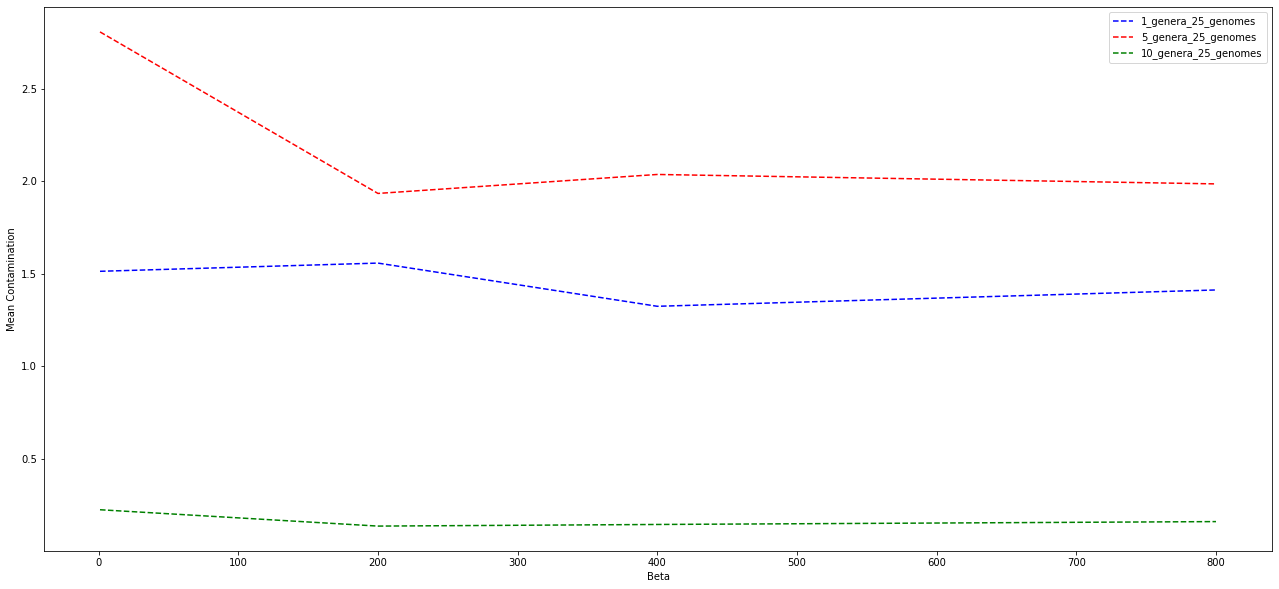

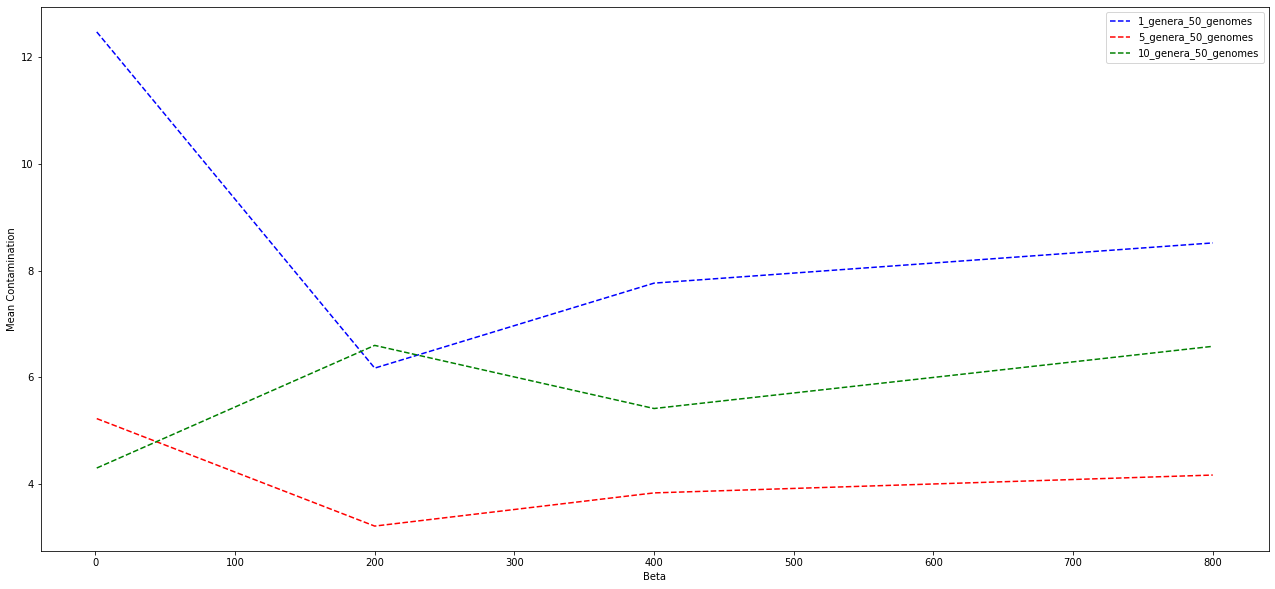

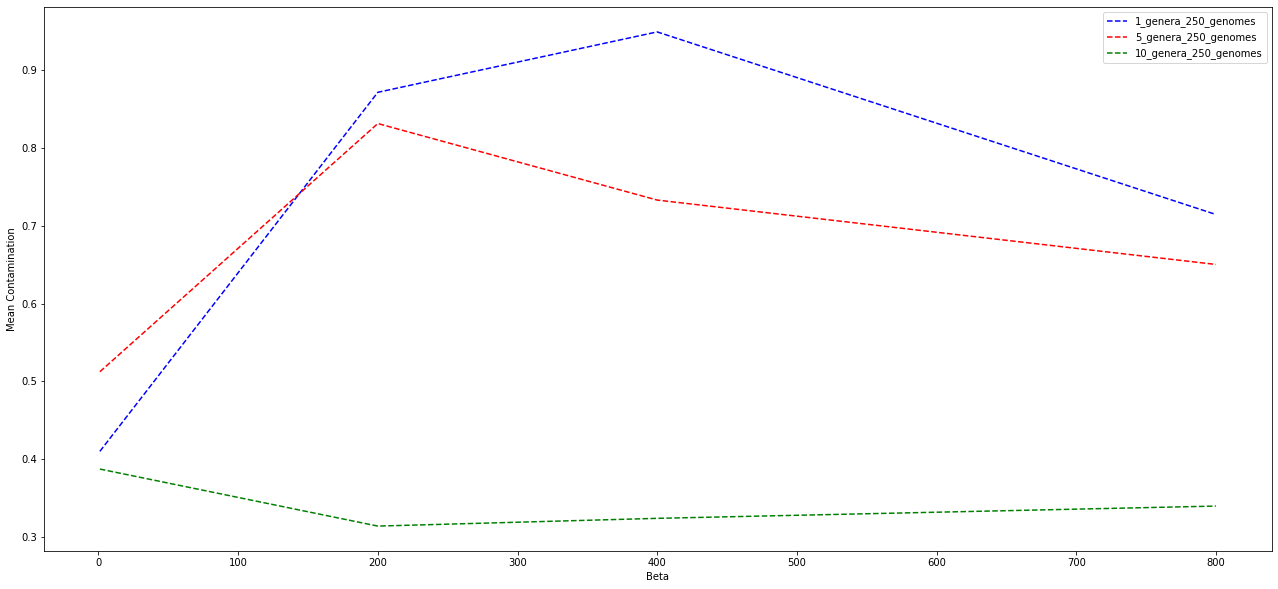

In [193]:
experiment_stats_all = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats*.tsv')])
experiment_stats_all = experiment_stats_all[experiment_stats_all['beta']<1000]
experiment_stats_all['experiment'] = experiment_stats_all['num_genera'].astype(str) + '_genera_' + experiment_stats_all['num_genomes'].astype(str) + '_genomes'
experiment_stats_all = experiment_stats_all.sort_values(by=['beta','num_genera','num_genomes'])


#fig = category_scatter(x='beta', y='mean_contamination', label_col='experiment', 
#                       data=experiment_stats_all, legend_loc='upper left')



colors = ['blue','red','green']

experiment_types = [25, 50, 250]

for experiment_type in experiment_types:
    experiment_type_df = experiment_stats_all[experiment_stats_all['num_genomes']==experiment_type]
    
    plt.figure(figsize=(22,10))

    for experiment, color in zip(experiment_type_df['experiment'].unique(), colors):
        experiment_df = experiment_type_df[experiment_type_df['experiment']==experiment]
        plt.plot(experiment_df['beta'], experiment_df['mean_contamination'], label=experiment, color=color, linestyle='--')


    plt.xlabel('Beta')
    plt.ylabel('Mean Contamination')
    plt.legend(loc='upper right')
    plt.show()

In [29]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,29,7,35.367005,0.387696,1,0.2
1,1,250,133,9,11.004557,0.410424,1,0.2
2,1,25,189,14,16.133731,1.513042,1,0.2
3,5,50,75,8,49.573638,5.219702,1,0.2
4,10,25,193,20,10.836362,0.224332,1,0.2
5,1,50,77,5,35.000355,12.480161,1,0.2
6,5,250,59,6,31.815141,0.512513,1,0.2
7,5,25,158,9,29.103874,2.806890,1,0.2
8,10,50,107,22,15.176583,4.291655,1,0.2


In [124]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,51,19,35.105822,0.314559,200,0.2
1,1,250,142,14,24.122196,0.870878,200,0.2
2,1,25,212,17,19.194367,1.557420,200,0.2
3,5,50,131,28,40.942619,3.201515,200,0.2
4,10,25,295,33,9.634855,0.135959,200,0.2
5,1,50,116,12,24.493177,6.167656,200,0.2
6,5,250,75,11,44.847036,0.830812,200,0.2
7,5,25,201,20,38.909649,1.933880,200,0.2
8,10,50,175,39,19.486343,6.594385,200,0.2


In [113]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,45,15,34.707670,0.324488,400,0.2
1,1,250,139,12,19.340885,0.948323,400,0.2
2,1,25,200,16,14.524375,1.323912,400,0.2
3,5,50,108,20,43.333994,3.824773,400,0.2
4,10,25,282,31,9.774104,0.144731,400,0.2
5,1,50,98,9,27.367071,7.763277,400,0.2
6,5,250,71,10,39.502991,0.732663,400,0.2
7,5,25,190,17,36.522143,2.036433,400,0.2
8,10,50,143,33,18.246001,5.409019,400,0.2


In [34]:
pd.read_csv(f"experiment_beta{experiment_beta}/experiment_stats_beta{experiment_beta}.tsv", sep='\t')

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
0,10,250,37,12,32.515300,0.340224,800,0.2
1,1,250,137,10,11.542033,0.714209,800,0.2
2,1,25,197,15,15.335927,1.412173,800,0.2
3,5,50,92,15,45.279762,4.159852,800,0.2
4,10,25,264,28,9.701293,0.160237,800,0.2
5,1,50,93,8,29.259742,8.518169,800,0.2
6,5,250,66,8,36.620047,0.650107,800,0.2
7,5,25,177,14,32.553189,1.985435,800,0.2
8,10,50,116,27,19.463007,6.576718,800,0.2


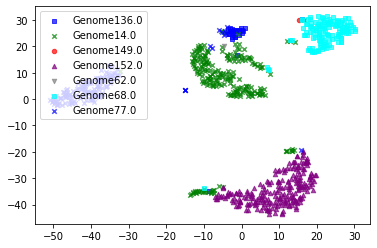

In [108]:
tsne_results = pd.read_csv('experiment_beta1/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')

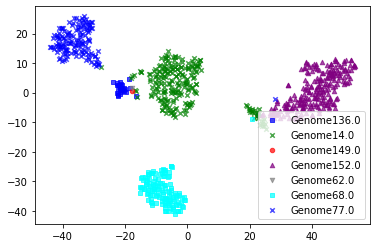

In [118]:
tsne_results = pd.read_csv('experiment_beta400/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='lower right')

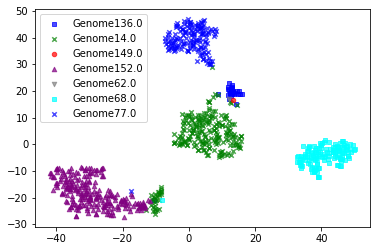

In [109]:
tsne_results = pd.read_csv('experiment_beta800/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')